# 🏷️ Part 1.2 – Categorizing Job Titles Using Supervised Learning

**Author:** Yu Kyung Koh  
**Last Updated:** July 5, 2025

---

### 🎯 Objective

* This notebook applies **supervised machine learning** methods—including logistic regression and multinomial Naive Bayes—to classify job titles into occupational categories.  
* In supervised learning, a model is trained on labeled examples (in this case, job titles with known categories) to learn patterns that can generalize to new, unseen titles.
* This approach is useful when manually labeled data is available and when scalable, automated classification is needed across large job posting datasets.
* Note that job category labels are known by design, as they were assigned during the LLM-based generation of synthetic job postings ([details here](https://github.com/yukyungkoh/job-postings-data-project/tree/main/0_generate-synthetic-job-postings)). For testing, we treat the categories as unknown and evaluate model predictions.
* **Caution:**
  * Since the data used in this notebook is synthetic, the supervised machine learning methods lead to **almost perfect** classification, as shown below.
  * This does **not** reflect performance on real job postings, where the model may not perform as well due to inherent noise and variability in real-world data.
  * While model comparison is difficult using the synthetic data as shown below, with real data, comparing model evaluation metrics shown here would help users guide which model performs better.
---

### 🗂️ Outline

- **Section 1:** Prepare the job posting data  
- **Section 2:** Train-test split  
- **Section 3:** Feature extraction using TF-IDF  
- **Section 4:** Method 1: Logistic regression  
- **Section 5:** Method 2: Multinomial Naive Bayes


---
## SECTION 1: Prepare the job posting data

In [3]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.preprocessing import LabelEncoder

In [4]:
## 1. Import cleaned data from code 1-1
datadir = '../data/'
jobposting_file = os.path.join(datadir, 'synthetic_job_postings_combined.csv')

posting_df = pd.read_csv(jobposting_file)

posting_df.head() 

,job_title,posting_text,sector
0,Educational Program Coordinator,We are seeking an enthusiastic Educational Pro...,education
1,Healthcare Data Analyst,We are seeking a detail-oriented Healthcare Da...,healthcare
2,Strategic Operations Consultant,"**Location:** Hybrid (New York, NY) \n**Salar...",consulting
3,Financial Operations Specialist,"**Location:** Hybrid (New York City, NY) \n**...",finance
4,Marketing Data Analyst,We are seeking a detail-oriented Marketing Dat...,marketing


In [5]:
posting_df.shape

(10877, 3)

In [6]:
## 2. Rename "sector" as "true_category"
posting_df.rename(columns={'sector': 'true_category'}, inplace=True)

In [7]:
## 3. Encode target labels
#  => This converts the category labels from text to numeric form, which is required by most scikit-learn models 

le = LabelEncoder()
posting_df['category_encoded'] = le.fit_transform(posting_df['true_category'])
print(posting_df.head())

                         job_title  \
0  Educational Program Coordinator   
1          Healthcare Data Analyst   
2  Strategic Operations Consultant   
3  Financial Operations Specialist   
4           Marketing Data Analyst   

                                        posting_text true_category  \
0  We are seeking an enthusiastic Educational Pro...     education   
1  We are seeking a detail-oriented Healthcare Da...    healthcare   
2  **Location:** Hybrid (New York, NY)  \n**Salar...    consulting   
3  **Location:** Hybrid (New York City, NY)  \n**...       finance   
4  We are seeking a detail-oriented Marketing Dat...     marketing   

   category_encoded  
0                 2  
1                 4  
2                 0  
3                 3  
4                 6  


In [8]:
## 4. Preview how many job postings are in each category
print(posting_df["category_encoded"].value_counts())

category_encoded
1     1054
7     1025
2     1014
9     1009
3      987
0      977
10     972
8      970
6      962
4      956
5      951
Name: count, dtype: int64


In [9]:
## 5. Combine job title and job description 

posting_df['all_text'] = posting_df['job_title'].fillna('') + ' ' + posting_df['posting_text'].fillna('')

In [10]:
## 6. Remove numbers and special characters 

def clean_text(text):
    text = re.sub(r'\d+', '', text)               # Remove digits
    text = re.sub(r'[^\w\s]', '', text)           # Remove special characters (keep only letters, numbers, spaces)
    text = re.sub(r'\s+', ' ', text)              # Collapse multiple spaces
    return text.strip()

posting_df['all_text'] = posting_df['all_text'].apply(clean_text)

---
## SECTION 2: Train-test split

* In this section, I split the dataset into training and test sets for supervised learning.  
* The `all_text` column -- containing job title and description -- is used as the input feature, and the `category_encoded` column serves as the target variable.  
* I use stratified sampling to ensure that the distribution of job categories is preserved across both the training and test sets.


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    posting_df['all_text'], 
    posting_df['category_encoded'], 
    test_size=0.5, 
    random_state=42, 
    stratify=posting_df['category_encoded']
)

In [13]:
X_train ## Contains "all_text" (variable used for prediction)

9643    Client Relationship Specialist In the fastpace...
2241    Consulting Analyst We are seeking a motivated ...
8757    Customer Experience Specialist We are looking ...
6076    Junior Business Consultant We are seeking a mo...
6771    Full Stack Developer Are you passionate about ...
                              ...                        
645     Financial Analyst III We are seeking a detailo...
9254    Finance Operations Coordinator Join a dynamic ...
3123    MidLevel Compliance Analyst We are seeking a d...
3832    Retail Operations Coordinator We are seeking a...
3953    Retail Operations Coordinator Are you ready to...
Name: all_text, Length: 5438, dtype: object

In [14]:
len(X_train)

5438

In [15]:
posting_df.shape

(10877, 5)

In [16]:
y_train ## Contains "category_encoded" (variable to be predicted)

9643     9
2241     0
8757     8
6076     0
6771    10
        ..
645      3
9254     3
3123     5
3832     8
3953     8
Name: category_encoded, Length: 5438, dtype: int64

---
## SECTION 3: Feature extraction (TF-IDF)

### 🔷 What is TF-IDF?

TF-IDF (Term Frequency–Inverse Document Frequency) is a widely used technique in text analysis that converts text into **numerical** features based on word importance.

Most machine learning algorithms -- including logistic regression, Naive Bayes, and SVM -- cannot directly work with raw text.  
Instead, the text must first be converted into a **numerical representation** that captures the relevant features of the input.  
TF-IDF is one of the most commonly used methods for this purpose in text classification tasks.


- **Term Frequency (TF):** Measures how often a word appears in a document.
- **Inverse Document Frequency (IDF):** Downweights words that appear frequently across all documents (e.g., "and", "the").

A high TF-IDF score means the word is frequent in a specific document but rare across the corpus — making it useful for distinguishing meaning. For example, the term "data scientist" might appear frequently in one job posting but rarely in others, giving it a high TF-IDF score and making it a strong signal for classification.



### 🔷 What I'm doing here

In this step, I use `TfidfVectorizer` from `scikit-learn` to transform the input job text (`all_text`) into a matrix of numerical features for model training.

- I extract both **unigrams and bigrams** (`ngram_range=(1, 2)`) as features.
- I set `max_features=500` to retain the top 500 most informative tokens. (You can change this number)
- I apply this transformation separately to the training and test sets, using `.fit_transform()` for training data and `.transform()` for test data.


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=500,
    stop_words='english',
    ngram_range=(1, 2),
    lowercase=True  # default behavior, included for clarity
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [19]:
X_train_tfidf  ## Each row = job posting, Each column = unigram or bigram 

<5438x500 sparse matrix of type '<class 'numpy.float64'>'
	with 492451 stored elements in Compressed Sparse Row format>

In [20]:
X_test_tfidf

<5439x500 sparse matrix of type '<class 'numpy.float64'>'
	with 492177 stored elements in Compressed Sparse Row format>

In [21]:
feature_names = tfidf.get_feature_names_out()
#print(feature_names) => View the top 500 unigrams/bigrams selected by TF-IDF

---
## SECTION 4: Logistic regression 

Logistic regression is a simple method for classification tasks. It models the probability that an input belongs to a particular class.

* In this case, it learns the relationship between the **TF-IDF features** (word frequencies) and **job categories.**
* The model assigns weights to each word (unigram or bigram), effectively learning which terms are **most predictive** of each job category.
* We use multinomial logistic regression since we have more than two job categories.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)   ## Training the logistic regression model using the train data 
    ## => Essentially doing a multinomial logistic regression
    ##    where Y-var is the job category 
    ##    and x_i is the TF-IDF score of a specific unigram or bigram 
    ##    Fitting 2000 coefficients 
y_pred_lr = lr_model.predict(X_test_tfidf)  ## Testing the model on the test data 

print("🔹 Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

🔹 Logistic Regression Results:
                      precision    recall  f1-score   support

          consulting       1.00      0.99      0.99       488
        data science       0.99      1.00      1.00       527
           education       1.00      1.00      1.00       507
             finance       1.00      0.99      1.00       494
          healthcare       1.00      0.99      1.00       478
               legal       0.99      1.00      1.00       475
           marketing       0.99      1.00      0.99       481
       public sector       0.99      1.00      1.00       513
              retail       1.00      1.00      1.00       485
               sales       1.00      1.00      1.00       505
software engineering       1.00      1.00      1.00       486

            accuracy                           1.00      5439
           macro avg       1.00      1.00      1.00      5439
        weighted avg       1.00      1.00      1.00      5439



In [24]:
y_pred_lr

array([7, 6, 6, ..., 7, 2, 5])

In [25]:
## Assign the predicted job categories (with the original category names)
# Step 1: Create a DataFrame for X_test (from Series or array)
X_test_df = pd.DataFrame(X_test, columns=['all_text'])  # Assuming X_test is a Series

# Step 2: Add the original category (y_test) to the DataFrame
X_test_df['original_category'] = le.inverse_transform(y_test)  # y_test contains the original encoded labels

# Step 3: Add the predicted job categories (y_pred_lr) to the DataFrame
X_test_df['job_category_logit'] = le.inverse_transform(y_pred_lr)

# Step 4: Display the first few rows with original and predicted categories
print(X_test_df[['all_text', 'original_category', 'job_category_logit']].head())

                                               all_text original_category  \
640   Community Outreach Coordinator The City of Spr...     public sector   
8826  Digital Marketing Strategist We are seeking a ...         marketing   
6756  Digital Marketing Strategist We are seeking a ...         marketing   
5120  Financial Data Analyst We are seeking a detail...           finance   
2522  Digital Marketing Coordinator We are seeking a...         marketing   

     job_category_logit  
640       public sector  
8826          marketing  
6756          marketing  
5120            finance  
2522          marketing  


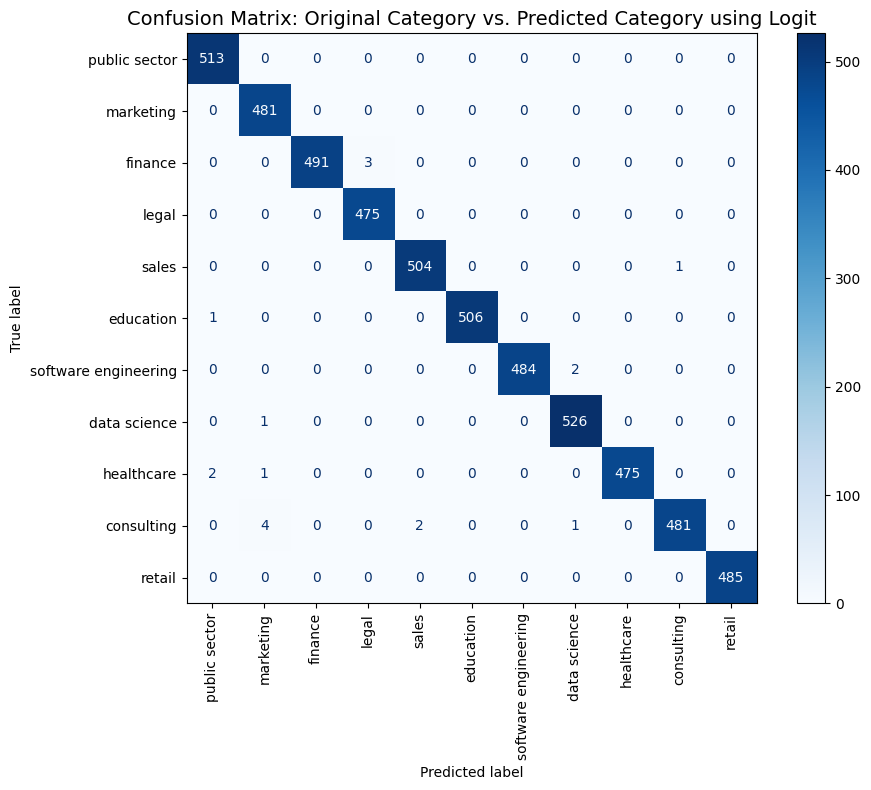

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(
    X_test_df["original_category"],  # True labels
    X_test_df["job_category_logit"],  # Predicted labels
    labels=X_test_df["original_category"].unique()  # Set the order of the labels (same as original categories)
)

# Plot with custom colormap and title
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=X_test_df["original_category"].unique()  # Display the original categories as labels
)

fig, ax = plt.subplots(figsize=(10, 8))  # Optional: adjust figure size
disp.plot(
    xticks_rotation=90,
    cmap="Blues", 
    ax=ax,
    colorbar=True
)
plt.title("Confusion Matrix: Original Category vs. Predicted Category using Logit", fontsize=14)
plt.tight_layout()
plt.show()

### 🔷 Comments on the Logistic Regression Results:

The logistic regression results are exceptionally strong with the synthetic job posting data.

* **Precision** is 100% for nearly all categories, meaning 100% of all jobs predicted as a certain category are correct.
* **Recall** is also 100%, meaning that all actual jobs in each category are correctly identified.
* The **F1-score** is perfect across all job categories.  
  * Note that the F1 score is $ F1 \: score = 2 \times \frac{Precision \times Recall}{Precision + Recall} $, which balances the trade-off between precision and recall.
* Overall, **accuracy** is 100%, indicating that the model correctly classified nearly all text examples.

This result is reflected in an almost perfect **diagonal matrix** in the confusion matrix.

⚠️ **CAUTION**:
* As noted earlier, this nearly perfect precision could be due to the use of **LLM-generated synthetic** data, which may have more consistent language and little noise across job postings. 
* These results may **not** hold with real-world job postings, which are much messier and noisier. 


---
## SECTION 5: Multinomial Naive Bayes

Multinomial Naive Bayes is another popular classification algorithm for discrete features like word counts or TF-IDF scores. 

####  🔷 How it differs from logistic regression:
  * **Example:** Suppose the word `"campaign"` appears frequently in Marketing job postings but rarely in others.
  * **Naive Bayes** asks "If this were a Marketing job, how likely is it that we’d see the word `"campaign"`?”
    * Estimates how likely the word `"campaign"` appears *within* each job category, such as $P(\text{campaign} \mid \text{Marketing})$,
    * And combines this with the _prior_ $P(\text{Marketing})$ to compute $P(\text{Marketing} \mid \text{campaign})$ using Bayes’ rule.
  
  * **Logistic regression** asks “Given that the word `"campaign"` appears, how much does that increase the odds that this is a Marketing job?”
      * Directly models the *posterior probability* $P(\text{Marketing} \mid \text{campaign})$
      * And assigns a positive weight to `"campaign"` if it helps predict the Marketing class.
      * It focuses on finding weights that best separate the classes by probability.

In [29]:
## Trying Naive Bayes using job descriptions 

from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("🔹 Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

🔹 Naive Bayes Results:
                      precision    recall  f1-score   support

          consulting       0.99      0.99      0.99       488
        data science       0.97      1.00      0.98       527
           education       1.00      0.99      0.99       507
             finance       0.99      0.99      0.99       494
          healthcare       0.99      0.99      0.99       478
               legal       0.99      1.00      0.99       475
           marketing       0.99      0.97      0.98       481
       public sector       0.98      0.99      0.99       513
              retail       1.00      1.00      1.00       485
               sales       1.00      0.99      0.99       505
software engineering       1.00      1.00      1.00       486

            accuracy                           0.99      5439
           macro avg       0.99      0.99      0.99      5439
        weighted avg       0.99      0.99      0.99      5439



### 🔷 Comments on Naive Bayes Results using **Job Descriptions**: 

While it is not obvious with the synthetic job posting data, Naive Bayes (when using job descriptions) may perform worse than logistic regression. This could happen due to 

1. **Strong (Unrealistic) Assumptions:** Naive Bayes assumes that all words are conditionally independent given the class.
But in natural language, that’s not true (e.g. words like "python" and "sql" offten co-occur). This independence assumption works okay on short texts, but breaks down with longer, richer descriptions.

2. **TF-IDF Doesn’t Fit Naive Bayes Perfectly:** Naive Bayes expects raw term frequencies (counts) to estimate probabilities. TF-IDF includes global weights, which distort those probabilities. Logistic Regression handles TF-IDF much better, since it doesn’t rely on probability theory - just feature weights

3. **Naive Bayes Struggles with Ambiguous Classes:** "Consultant" may appear in job posts that also use words like “business”, “marketing”, “project” → easily confused. Logistic Regression handles correlated features much better.

4. **Logistic Regression Learns Interactions More Flexibly:** Logistic regression learns feature weights directly from data. For example, it can learn that "data" + "engineer" = Data job OR "project" + "manager" = Project Manager

Naives Bayes may work better with short documents, few classes, and clean, non-overlapping vocabulary

